In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from lazypredict.Supervised import LazyClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('Clicked Ads Dataset.csv', index_col = [0])

In [3]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
0,68.95,35,432837300.00,256.09,Perempuan,3/27/2016 0:53,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Furniture
1,80.23,31,479092950.00,193.77,Laki-Laki,4/4/2016 1:39,No,Denpasar,Bali,Food
2,69.47,26,418501580.00,236.50,Perempuan,3/13/2016 20:35,No,Surabaya,Jawa Timur,Electronic
3,74.15,29,383643260.00,245.89,Laki-Laki,1/10/2016 2:31,No,Batam,Kepulauan Riau,House
4,68.37,35,517229930.00,225.58,Perempuan,6/3/2016 3:36,No,Medan,Sumatra Utara,Finance


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Age                       1000 non-null   int64  
 2   Area Income               987 non-null    float64
 3   Daily Internet Usage      989 non-null    float64
 4   Male                      997 non-null    object 
 5   Timestamp                 1000 non-null   object 
 6   Clicked on Ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 85.9+ KB


In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# EDA : Customer Type and Behaviour Analysis on Advertisement

## Get the data type of each row in the dataset

In [6]:
cat = []
num = []
dat = []

numeric = ['int64', 'int32', 'float64']

for i in df.columns:
    data_type = str(df[i].dtype)
    if data_type == 'object' :
        cat.append(i)
    elif data_type in numeric :
        num.append(i)
    else:
        dat.append(i)

In [7]:
cat

['Male', 'Clicked on Ad', 'city', 'province', 'category']

### See the distribution of data

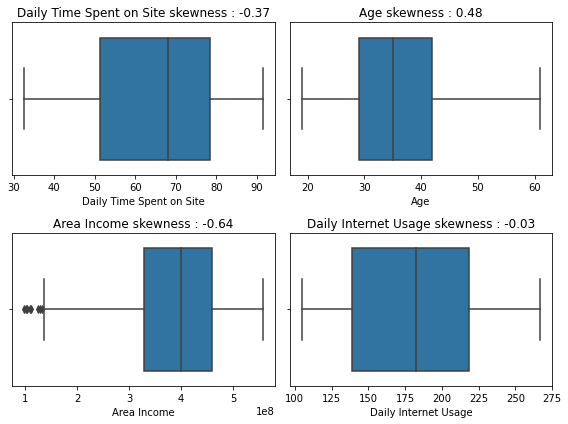

In [8]:
plt.figure(figsize=(8,6))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(2,2,i)
    sns.boxplot(data=df[num], x=df[column])
    plt.title(str(column) + ' skewness : ' + str(np.round(df[column].skew(), 2)))
    plt.tight_layout()

From the picture above, we know that area income is an outlier, but it is logical because some areas have a low income than other places.

and only daily internet usage has a nearly to be normal distribution, other columns are skewed.

In [9]:
df[cat].describe().transpose()

,count,unique,top,freq
Male,997,2,Perempuan,518
Clicked on Ad,1000,2,No,500
city,1000,30,Surabaya,64
province,1000,16,Daerah Khusus Ibukota Jakarta,253
category,1000,10,Otomotif,112


## Univariate Analysis

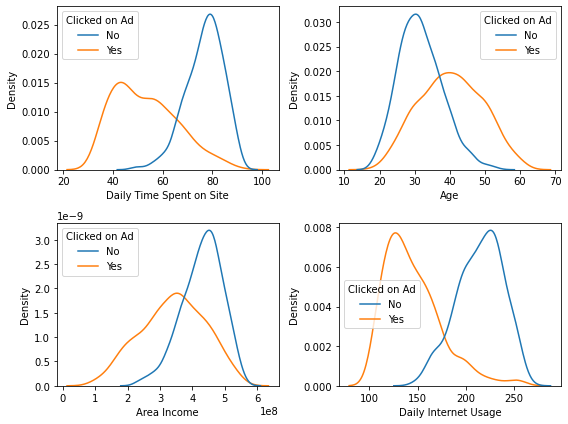

In [10]:
plt.figure(figsize=(8,6))

for i, column in enumerate (df[num].columns, 1):
    plt.subplot(2,2,i)
    sns.kdeplot(data=df[num], x=df[column], hue=df['Clicked on Ad'])
    plt.tight_layout()

From the graph, we know that customer tend to click our ad if they have <=60 daily time spent on our site, are >=40 years old. have an income <=3 * 10^8 rupiah and have <=170 daily internet usage.

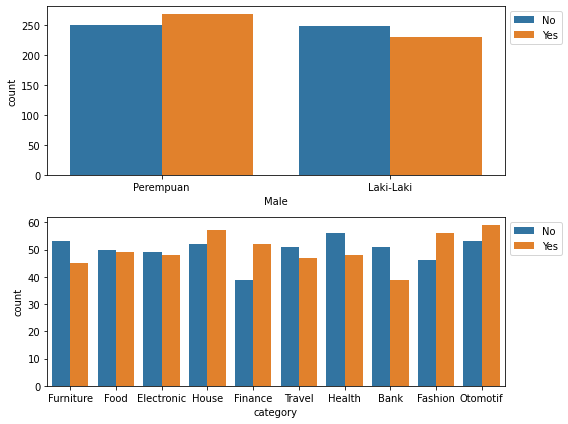

In [11]:
cat_2 = ['Male', 'category'] 

plt.figure(figsize=(8,6))

for i, column in enumerate (df[cat_2].columns, 1):
    plt.subplot(2,1,i)
    sns.countplot(data=df[cat_2], x=df[column], hue=df['Clicked on Ad'])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

From the graph, we know that woman have a percentage above 50% to click on our ads, and customer is more interested with our ads about house, finance, fashion and automotive,this can be said because of the percentage customer click our ads above 50%.

## Bivariate Analysis

<Figure size 576x576 with 0 Axes>

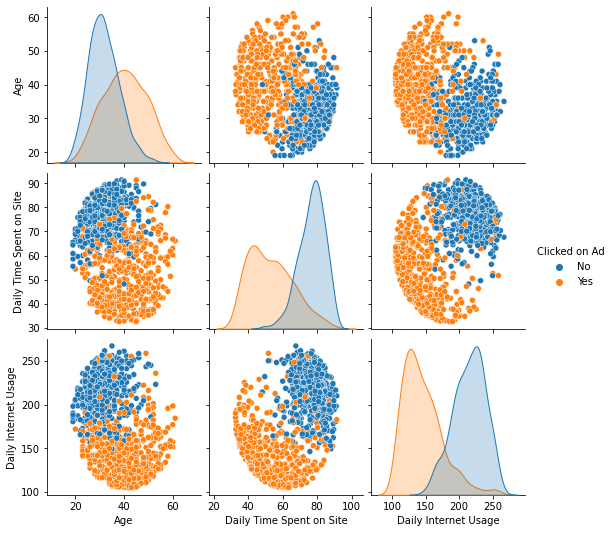

In [12]:
num_2 = ['Age', 'Daily Time Spent on Site', 'Daily Internet Usage', 'Clicked on Ad']

plt.figure(figsize=(8, 8))
sns.pairplot(df[num_2], diag_kind='kde', hue='Clicked on Ad')
plt.show()

from the graph, we know :
1. The older our customer, have a few daily time spent on site and daily internet usage they tend to click our ads.
2. The younger our customer, have a more daily time spent on site and daily internet usage they tend to not click our ads.

## Multivariate Analysis

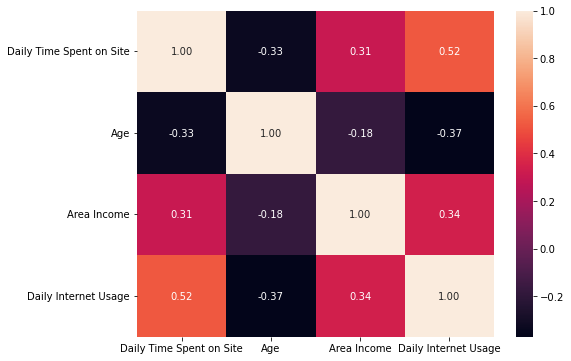

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

From graph, we know that Daily Internet Usage and Daily Time spent on site have a highest correlation between another column, the second highest correlation is Age with Daily Internet Usage and the third is area income with daily internet usage.

In [14]:
col_1 = []
col_2 = []
p_value = []

for col1 in cat:
    for col in cat:
        if col1 != col:
            # create the contingency table
            contingency_table = pd.crosstab(df[col1], df[col])

            # calculate the chi-squared test
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            col_1.append(col1)
            col_2.append(col)
            p_value.append(p)
        else:
            continue

In [15]:
cor = pd.DataFrame({'Column' : col_1, 'Category column' : col_2, 'P_value from chi square' : p_value})

In [16]:
cor2 = cor.drop_duplicates(subset=['P_value from chi square'])
cor2.sort_values('P_value from chi square', ascending=True)

,Column,Category column,P_value from chi square
10,city,province,0.00
5,Clicked on Ad,city,0.21
3,Male,category,0.23
0,Male,Clicked on Ad,0.30
11,city,category,0.36
13,province,Clicked on Ad,0.38
6,Clicked on Ad,province,0.38
2,Male,province,0.43
1,Male,city,0.47
8,city,Male,0.47


From table above, we know that clicked on Ad have a high correlation with city and  Male with category.

# Data Cleaning & Prepocessing

## Fix Missing Value

In [17]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
count_nv[count_nv['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
0,Daily Time Spent on Site,13,1.30
2,Area Income,13,1.30
3,Daily Internet Usage,11,1.10
4,Male,3,0.30


In [18]:
column = count_nv[count_nv['Percentage'] != 0]['index']
df[column].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  987 non-null    float64
 1   Area Income               987 non-null    float64
 2   Daily Internet Usage      989 non-null    float64
 3   Male                      997 non-null    object 
dtypes: float64(3), object(1)
memory usage: 71.4+ KB


For numeric column, we will fill null data with median and for object column we fill null data with mode.

In [19]:
for i in column:
    data_type = str(df[i].dtype)
    if data_type == 'object' :
        df[i] = df[i].fillna(df[i].mode()[0])
    elif data_type in numeric :
        df[i] = df[i].fillna(df[i].median())

In [20]:
df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Male                        0
Timestamp                   0
Clicked on Ad               0
city                        0
province                    0
category                    0
dtype: int64

## Check Duplicate Value

In [21]:
df.duplicated().sum()

0

Our Dataset dont have a duplicate rows, so we dont need to delete any column here.

## Feature Encoding

### Extract datetime data

In [22]:
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df["Weekday"] = df['Timestamp'].dt.dayofweek
df["is_weekend"] = np.where(df['Weekday'].isin([5,6]) == True, 1,0)

df.drop(columns = 'Timestamp', inplace=True)

### Divide category column to 2 depend on their total unique value.

In [23]:
cat_1 = []
cat_2 = []

for i in cat:
    unique_value = len(df[i].unique())
    if unique_value > 2:
        cat_2.append(i)
    else:
        cat_1.append(i)

In [24]:
cat_1

['Male', 'Clicked on Ad']

### Label Encoding in Manual Way

In [25]:
df['Male'] = np.where(df['Male'] == 'Laki-Laki', 1, 0)
df['Clicked on Ad'] = df['Clicked on Ad'].apply(lambda x: 0 if x == 'No' else 1)

### One-Hot Encoding

In [26]:
for i in cat_2:
    onehots = pd.get_dummies(df[i], prefix=i)
    df = df.join(onehots)
    
df.drop(columns = cat_2, inplace=True)

### Scalling Numeric column with standard scaler in manual way

Usually you can use standarscaler function with this step :
1. Import standardscaler

from sklearn.preprocessing import StandardScaler
 
2. Do the standardize

df[col_names] = StandardScaler().fit_transform(df[col_names].values)

but i choose to use manual way to tell reader the formula of standard scaler.

In [27]:
df_non_normalization = df.copy()

In [28]:
num.extend(['Year', 'Month', 'Day', 'Weekday'])

In [29]:
df[num].head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Year,Month,Day,Weekday
0,68.95,35,432837300.00,256.09,2016,3,27,6
1,80.23,31,479092950.00,193.77,2016,4,4,0
2,69.47,26,418501580.00,236.50,2016,3,13,6
3,74.15,29,383643260.00,245.89,2016,1,10,6
4,68.37,35,517229930.00,225.58,2016,6,3,4


In [30]:
# Normalisasi fitur numerik
num_mean = df[num].mean()
num_std  = df[num].std()

df[num] = (df[num] - num_mean) / num_std
df[num].head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Year,Month,Day,Weekday
0,0.25,-0.11,0.51,1.75,NaN,-0.42,1.32,1.47
1,0.97,-0.57,1.01,0.32,NaN,0.09,-1.31,-1.53
2,0.29,-1.14,0.36,1.30,NaN,-0.42,-0.28,1.47
3,0.58,-0.80,-0.02,1.51,NaN,-1.46,-0.63,1.47
4,0.22,-0.11,1.41,1.05,NaN,1.13,-1.43,0.47


In [31]:
df.Year = df.Year.fillna(1)

## Split data to feature and Target

In [32]:
feature = df.drop(columns = 'Clicked on Ad')
target = df['Clicked on Ad']

In [33]:
target.value_counts()

0    500
1    500
Name: Clicked on Ad, dtype: int64

Because target have balanced amount, we dont need to oversampling the data.

In [34]:
feature_2 = df_non_normalization.drop(columns = 'Clicked on Ad')
target_2  = df_non_normalization['Clicked on Ad']

# Modelling

For this modelling, we will do some experiment, there are :

    1. First model will be trained by data that numeric columns dont do a scaling
    2. Second model will be trained by data that has passed all data preprocessing
    
And in this case, I will try library called Lazypredict to make a model, and another will be i try are LightGBM, RandomForest and XGBoost.

for install lazypredict library and another model, u can run my requirement at my github.

## Experiment 1

In [35]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(feature_2, target_2, test_size = 0.2, random_state=1)

In [36]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

In [37]:
models,predictions = clf.fit(x_train1, x_test1, y_train1, y_test1)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 19.07it/s]


In [38]:
model_dictionary = clf.provide_models(x_train1,x_test1,y_train1,y_test1)
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.96,0.96,0.96,0.96,0.14
RandomForestClassifier,0.96,0.96,0.96,0.96,0.17
LGBMClassifier,0.95,0.95,0.95,0.95,0.17
BaggingClassifier,0.95,0.95,0.95,0.95,0.04
LogisticRegression,0.94,0.94,0.94,0.94,0.02
AdaBoostClassifier,0.94,0.94,0.94,0.94,0.12
LinearSVC,0.94,0.94,0.94,0.94,0.02
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.18
CalibratedClassifierCV,0.94,0.94,0.94,0.94,0.08


## Experiment 2

In [39]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(feature, target, test_size = 0.2, random_state=1)

In [40]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)

In [41]:
models_2 ,predictions = clf.fit(x_train2, x_test2, y_train2, y_test2)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 20.10it/s]


In [42]:
model_dictionary = clf.provide_models(x_train2,x_test2,y_train2,y_test2)
models_2

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.96,0.96,0.96,0.96,0.09
RandomForestClassifier,0.96,0.96,0.96,0.96,0.15
LGBMClassifier,0.95,0.95,0.95,0.95,0.17
BaggingClassifier,0.95,0.95,0.95,0.95,0.04
LogisticRegression,0.94,0.94,0.94,0.94,0.02
AdaBoostClassifier,0.94,0.94,0.94,0.94,0.23
LinearSVC,0.94,0.94,0.94,0.94,0.02
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.14
CalibratedClassifierCV,0.94,0.94,0.94,0.94,0.11


## Result from Experiment

In [43]:
models_2c = models_2.copy().reset_index()

a = list(models_2c.columns)
a = [item + ' exp_2' for item in a]

models_2c.columns = a

models = models.reset_index()
result = pd.merge(models, models_2c, left_on='Model', right_on='Model exp_2')

In [44]:
result.drop(columns = 'Model exp_2')

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken,Accuracy exp_2,Balanced Accuracy exp_2,ROC AUC exp_2,F1 Score exp_2,Time Taken exp_2
0,XGBClassifier,0.96,0.96,0.96,0.96,0.14,0.96,0.96,0.96,0.96,0.09
1,RandomForestClassifier,0.96,0.96,0.96,0.96,0.17,0.96,0.96,0.96,0.96,0.15
2,LGBMClassifier,0.95,0.95,0.95,0.95,0.17,0.95,0.95,0.95,0.95,0.17
3,BaggingClassifier,0.95,0.95,0.95,0.95,0.04,0.95,0.95,0.95,0.95,0.04
4,LogisticRegression,0.94,0.94,0.94,0.94,0.02,0.94,0.94,0.94,0.94,0.02
5,AdaBoostClassifier,0.94,0.94,0.94,0.94,0.12,0.94,0.94,0.94,0.94,0.23
6,LinearSVC,0.94,0.94,0.94,0.94,0.02,0.94,0.94,0.94,0.94,0.02
7,ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.18,0.94,0.94,0.94,0.94,0.14
8,CalibratedClassifierCV,0.94,0.94,0.94,0.94,0.08,0.94,0.94,0.94,0.94,0.11
9,DecisionTreeClassifier,0.94,0.93,0.93,0.93,0.01,0.94,0.93,0.93,0.93,0.02


From the experiment, we can see XGBoost classifier with data that has passed all data preprocessing have the best evaluation parameter where who make the difference between two experiment is time taken, model with data have been preprocessed have a fewer time to process the data.

## Make XGBoost model

In [45]:
XGB_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
XGB_model.fit(x_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

## Model Evaluation

### In test data

In [54]:
def confusionmatrix(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did not Click','Click'])
    return disp.plot()

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       103
           1       1.00      0.92      0.96        97

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



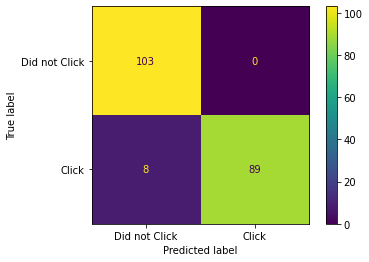

In [55]:
predictions = XGB_model.predict(x_test2)
  
# print classification report
print(classification_report(y_test2, predictions))
confusionmatrix(y_test2, predictions)

### In training data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       397
           1       1.00      1.00      1.00       403

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



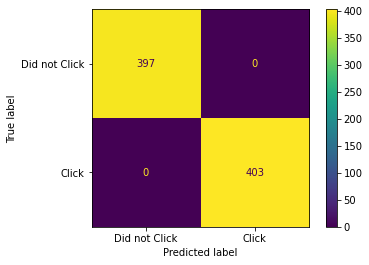

In [56]:
predictions = XGB_model.predict(x_train2)
  
# print classification report
print(classification_report(y_train2, predictions))
confusionmatrix(y_train2, predictions)

We can see at when model was tested with training data, model have 100% accuracy, and at test data model have 96% accuracy, it signifies that our model not overfitting and we have good data.

### Feature Importance

<AxesSubplot:>

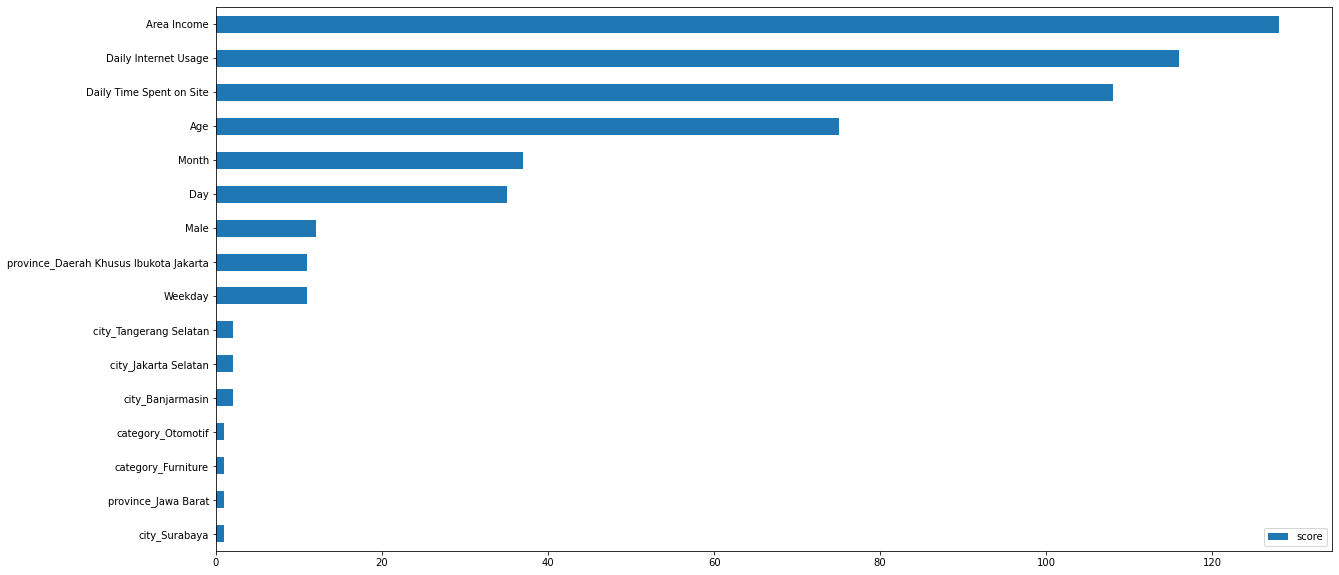

In [60]:
feature_important = XGB_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").sort_values('score', ascending=True).plot(kind='barh', figsize = (20,10)) ## plot top 40 features

# Business Recommendation

Based on Anaysis and feature importance from model, it can be concluded that :

1. We need to increase showing our ads to customer that meet the following requirement : They have income maximum 3.2 hundred million, are >=40 years old, have <= 60 minutes daily time spent on our site and  have <= 170 minutes daily internet usage.

2. For customer that don’t meet criteria at number 1, we need to decrease showing our ads because they are have low amount customer to click our ads. So that we can maximize our budget in advertising.

## Model Bases - Simulation

We have a balanced amount of data between targets (50% click our ads and 50% no click our ads). Let’s count if we don’t use our model/do business recommendation :

Assumption : 

We show our ads at Google searchs Ads that have average CPM 38.40 USD (at 2021 via topdraw.com), 
let’s say if customer click our ads we got $0.1. so :

Cost : $38.40

Revenue = (1000 * 50%) * $0.1 = $50

Profit = Revenue – Cost = $50 - $38.40 = $11.6

Now if we use a ML model that has 96% accuracy to determine whether our customers will see our ads or not. We can get a profit per 1000 views of (We use the same assumption as before) :

Cost : $38.40

Revenue = (1000 * 96%) * $0.1 = $96

Profit = Revenue – Cost = $96 - $38.40 = $57.6

Is nearly 5 times bigger than if we don’t use ML model.